In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

from tqdm import tqdm
import random
import numpy as np
from PIL import Image

### Импортируем данные

In [4]:
sample = pd.read_csv('/kaggle/input/nn-image/sample_submission.csv')
train_lablels = pd.read_csv('/kaggle/input/nn-image/train_labels.csv')

### Посмотрим, сколько классов и визуально оценим распределение

In [5]:
len(train_lablels['label'].unique())

151

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


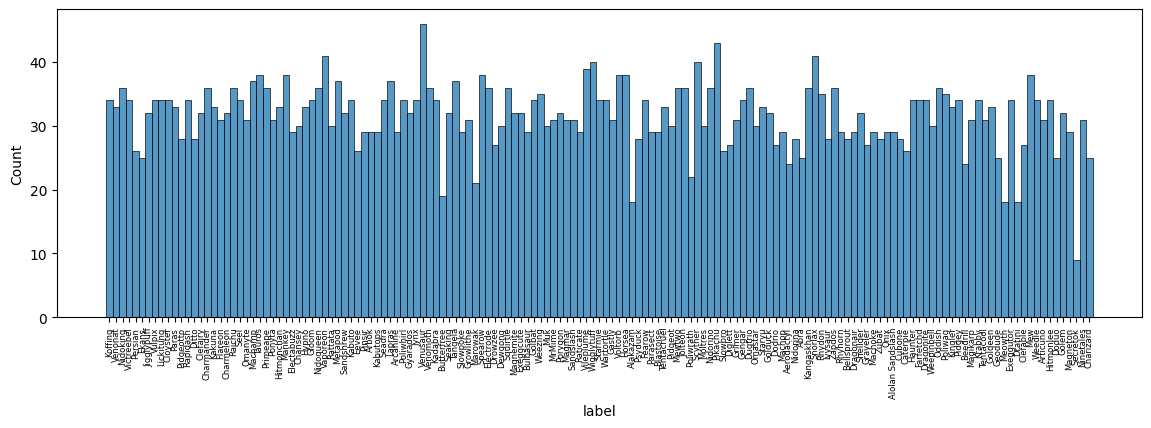

In [6]:
plt.figure(figsize=(14, 4))
sns.histplot(train_lablels['label'])

plt.xticks(rotation=90)
plt.xticks(fontsize=6)

plt.show()

### Видим 151 покемона без сильного дисбаланса классов

In [7]:
train_lablels['label'].value_counts()

label
Venusaur      46
Pikachu       43
Snorlax       41
Vaporeon      41
Wigglytuff    40
              ..
Butterfree    19
Dratini       18
Alakazam      18
Meowth        18
Secretok       9
Name: count, Length: 151, dtype: int64

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Загрузим готовую модель resnet18

In [9]:
# загружаем модель
model = models.resnet18()

# загружаем веса
model.load_state_dict(torch.load('/kaggle/input/resnet_18/pytorch/default/1/resnet18-f37072fd.pth'))

# в последнем слое указываем количество классов
num_classes = 151
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [10]:
# определим пути к данным 
train_data_dir = '/kaggle/input/train-structured/train_structured'

# определим трансформации
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# создадим датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)

# создадим датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
classes_list = train_dataset.classes
print(classes_list)

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

### Обучение сети

In [ ]:
# определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# число эпох
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

 13%|█▎        | 10/75 [01:26<09:22,  8.66s/it]

In [ ]:
train_accuracy
# 1st_train_accuracy = 0.6356589147286822

Код для сохранения модели

In [140]:
# torch.save(model.state_dict(), 'seven_epochs.pth')

#### Подготовим функции для предсказаний

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


class TestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]  # Возвращаем имя файла как метку (если нужно)

# путь к тестовым данным на Kaggle
test_folder = '/kaggle/input/nn-image/train_test_data/test'
test_dataset = TestDataset(test_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Ставим модель в режим оценки и делаем предсказания на тестовых данных

In [ ]:
model.eval()  # модель в режим оценки
all_predictions = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # классы с максимальной вероятностью
        all_predictions.extend(zip(filenames, predicted.cpu().numpy()))  # сохраняем предсказания с именами файлов

# Вывод результатов
# for filename, prediction in all_predictions:
#     print(f'Image: {filename}, Predicted class: {prediction}')

### Собираем файл для сабмита

In [ ]:
classes_df = pd.DataFrame(classes_list)

In [ ]:
classes_df = classes_df.reset_index()

In [ ]:
preds_df = pd.DataFrame(all_predictions, columns=['filename', 'label'])

In [ ]:
submission = preds_df.merge(classes_df, left_on='label', right_on='index')

In [ ]:
submission['label'] = submission.iloc[:, 3]

In [ ]:
long_submission = submission[['filename', 'label']]

In [ ]:
long_submission.to_csv('/kaggle/working/long_submission.csv', index=False)

### Делаем сабмит и получаем такой результат для 7 эпох:

#### public score: 0.956989

### Попробуем обучить самописную нейросеть

In [14]:
# определение модели
class CustomCNN(nn.Module):
    def __init__(self, num_classes=151):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.avgpool(x)  # Сжимаем до 1x1
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [15]:
# определим пути к данным 
train_data_dir = '/kaggle/input/train-structured/train_structured'

# трансформации для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.ToTensor(),
])

# создадим датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)

# создадим датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# создание экземпляра модели
custom_model = CustomCNN(num_classes=len(train_dataset.classes)).to(device)

# определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

### Обучаем сеть
**Запустим на одну эпоху, чтобы проверить бейзлайн**

In [20]:
custom_num_epochs = 1
for epoch in range(custom_num_epochs):
    custom_model.train()  # переводим модель в режим обучения
    running_loss = 0.0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # обнуление градиентов
        optimizer.zero_grad()
        
        # прямой проход
        outputs = custom_model(inputs)
        
        # вычисление потерь
        loss = criterion(outputs, labels)
        
        # обратный проход
        loss.backward()
        
        # обновление параметров
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)

100%|██████████| 75/75 [07:46<00:00,  6.22s/it]


In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


class TestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]  # возвращаем имя файла как метку

# путь к тестовым данным на Kaggle
test_folder = '/kaggle/input/nn-image/train_test_data/test'
test_dataset = TestDataset(test_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Делаем предсказания

In [33]:
custom_model.eval()  # режим оценки
all_predictions = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = custom_model(images)
        _, predicted = outputs.max(1)  # классы с максимальной вероятностью
        all_predictions.extend(zip(filenames, predicted.cpu().numpy()))  # предсказания с именами файлов

# for filename, prediction in all_predictions:
#     print(f'Image: {filename}, Predicted class: {prediction}')

100%|██████████| 32/32 [01:39<00:00,  3.11s/it]


In [26]:
classes_df = pd.DataFrame(classes_list)
classes_df = classes_df.reset_index()
preds_df = pd.DataFrame(all_predictions, columns=['filename', 'label'])

In [28]:
submission = preds_df.merge(classes_df, left_on='label', right_on='index')
submission['label'] = submission.iloc[:, 3]
custom_submission = submission[['filename', 'label']]

In [ ]:
custom_submission.to_csv('/kaggle/working/custom_submission.csv', index=False)

### Засабмитим и посмотрим, что получилось

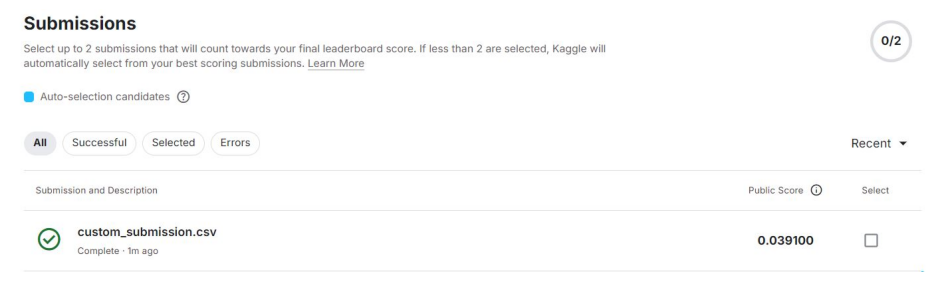

In [32]:
path = '/kaggle/input/custom-submission/custom_submission.JPG'

image = mpimg.imread(path)


plt.figure(figsize=(12,8))
plt.imshow(image)
plt.axis('off')
plt.show()

**Бейзлайн побит, тюнить можно долго, + поставить обучаться на подольше, но гораздо эффективнее было работать с уже готовой архитектурой**